In [86]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq    

In [87]:
# cols = []   ##TODO: Specify desired columns here
df_base = pd.read_parquet("MSTR_Options_cleaned.parquet", engine="pyarrow")
df_base.head()

,Timestamp,Stock Price,Symbol,Option Type,Strike Price,Ask Price,Bid Price,Expiration Date
0,2024-08-09,135.37,MSTR240816C00080000,call,80.0,56.35,54.80,2024-08-16
1,2024-08-09,135.37,MSTR240816C00082000,call,82.0,54.45,52.75,2024-08-16
2,2024-08-09,135.37,MSTR240816C00100000,call,100.0,36.30,35.00,2024-08-16
3,2024-08-09,135.37,MSTR240816C00105000,call,105.0,32.15,30.25,2024-08-16
4,2024-08-09,135.37,MSTR240816C00108000,call,108.0,28.85,27.05,2024-08-16


# Initial Transformations 

## Add Returns

In [88]:
df_base['Stock.Price_Lag1'] = df_base.groupby('Symbol')['Stock Price'].shift(1)
df_base['Returns'] = (df_base['Stock Price'] - df_base['Stock.Price_Lag1']) / df_base['Stock.Price_Lag1']
df_base[['Stock Price', 'Stock.Price_Lag1', 'Returns']].head()

,Stock Price,Stock.Price_Lag1,Returns
0,135.37,NaN,NaN
1,135.37,NaN,NaN
2,135.37,NaN,NaN
3,135.37,NaN,NaN
4,135.37,NaN,NaN


## Addressing Missing Values from Lagged Variable Calculation

In [89]:
# Analyze missing percentages for lagged columns
lag_cols = ['Stock.Price_Lag1']

# Calculate missing percentages
missing_stats = pd.DataFrame({
    'Lagged Column': lag_cols,
    'Missing %': [df_base[col].isna().mean() * 100 for col in lag_cols],
    'Missing Count': [df_base[col].isna().sum() for col in lag_cols],
    'Total Rows': len(df_base)
})

print("Missing Value Analysis (Stock Price Dependent Features Removed):")
print("-" * 80)
print(missing_stats.round(2))

# Analyze if missing values in lagged columns correspond to first observations
first_obs_by_symbol = df_base.groupby('Symbol').size()
print(f"\nNumber of unique symbols: {len(first_obs_by_symbol)}")
print(f"Expected first observations (no lag available): {len(first_obs_by_symbol)}")
print(f"Actual missing in lag columns: {df_base['Stock.Price_Lag1'].isna().sum()}")

# Show distribution of observations per symbol
print("\nDistribution of observations per symbol:")
obs_stats = first_obs_by_symbol.describe().round(2)
print(obs_stats)

# Optional: Show symbols with most observations
print("\nTop 5 symbols by number of observations:")
print(first_obs_by_symbol.sort_values(ascending=False).head())


Missing Value Analysis (Stock Price Dependent Features Removed):
--------------------------------------------------------------------------------
      Lagged Column  Missing %  Missing Count  Total Rows
0  Stock.Price_Lag1       2.32          26968     1161031

Number of unique symbols: 26968
Expected first observations (no lag available): 26968
Actual missing in lag columns: 26968

Distribution of observations per symbol:
count    26968.00
mean        43.05
std         62.59
min          1.00
25%          7.00
50%         18.00
75%         37.00
max        264.00
dtype: float64

Top 5 symbols by number of observations:
Symbol
MSTR260116C00154000    264
MSTR260116C00145000    264
MSTR260116C00135000    264
MSTR260116C00136000    264
MSTR260116C00129000    264
dtype: int64


In [90]:
# Store original size
original_size = len(df_base)

# Drop missing values
df_base_clean = df_base.dropna(subset=lag_cols)

# Calculate impact
rows_dropped = original_size - len(df_base_clean)
percent_dropped = (rows_dropped / original_size) * 100

print(f"Impact of dropping missing lag values:")
print(f"Original rows: {original_size:,}")
print(f"Rows after dropping missing: {len(df_base_clean):,}")
print(f"Rows dropped: {rows_dropped:,} ({percent_dropped:.2f}%)")

# Show distribution of remaining data
print("\nDistribution of observations per symbol after dropping missing values:")
remaining_obs_by_symbol = df_base_clean.groupby('Symbol').size()
print(remaining_obs_by_symbol.describe().round(2))

# Verify no missing values remain
print("\nVerifying no missing values remain in lag columns:")
print(df_base_clean[lag_cols].isna().sum())

# Assign cleaned dataset back to df_base
df_base = df_base_clean


Impact of dropping missing lag values:
Original rows: 1,161,031
Rows after dropping missing: 1,134,063
Rows dropped: 26,968 (2.32%)

Distribution of observations per symbol after dropping missing values:
count    26455.00
mean        42.87
std         62.91
min          1.00
25%          6.00
50%         18.00
75%         37.00
max        263.00
dtype: float64

Verifying no missing values remain in lag columns:
Stock.Price_Lag1    0
dtype: int64


In [91]:
df_base

,Timestamp,Stock Price,Symbol,Option Type,Strike Price,Ask Price,Bid Price,Expiration Date,Stock.Price_Lag1,Returns
3009,2024-08-13,135.380,MSTR240816C00080000,call,80.0,53.75,49.00,2024-08-16,135.37,0.000074
3010,2024-08-13,135.380,MSTR240816C00082000,call,82.0,51.25,46.95,2024-08-16,135.37,0.000074
3014,2024-08-13,135.380,MSTR240816C00100000,call,100.0,34.20,30.90,2024-08-16,135.37,0.000074
3015,2024-08-13,135.380,MSTR240816C00105000,call,105.0,28.00,25.15,2024-08-16,135.37,0.000074
3017,2024-08-13,135.380,MSTR240816C00108000,call,108.0,25.10,22.95,2024-08-16,135.37,0.000074
...,...,...,...,...,...,...,...,...,...,...
1237115,2025-10-30,253.935,MSTR280121P00420000,put,420.0,208.30,202.40,2028-01-21,274.39,-0.074547
1237116,2025-10-30,253.935,MSTR280121P00430000,put,430.0,216.55,210.55,2028-01-21,274.39,-0.074547
1237117,2025-10-30,253.935,MSTR280121P00450000,put,450.0,233.00,226.60,2028-01-21,274.39,-0.074547
1237118,2025-10-30,253.935,MSTR280121P00470000,put,470.0,249.80,243.60,2028-01-21,274.39,-0.074547


## Scale Returns Distribution

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

X = df_base['Returns']
X.describe()

count    1.134063e+06
mean     3.695815e-03
std      6.744385e-02
min     -1.945740e-01
25%     -2.617205e-02
50%     -1.132211e-03
75%      2.607188e-02
max      2.500776e+00
Name: Returns, dtype: float64

## Normality Checks 

Text(0, 0.5, 'Scaled Returns')

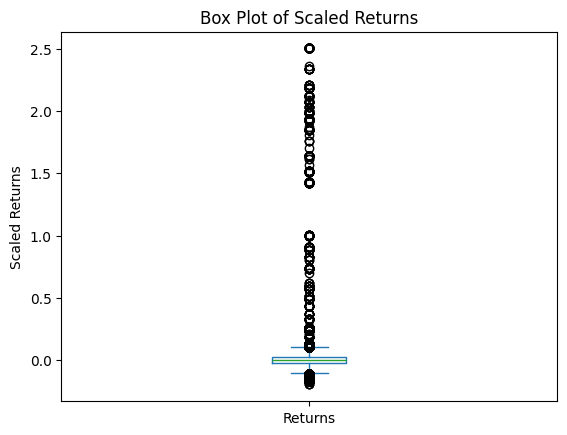

In [ ]:
box = X.plot.box(title="Box Plot of Returns")
plt.ylabel("Returns")    

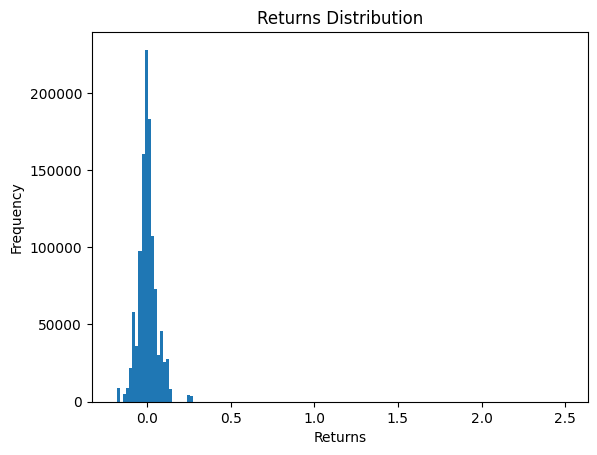

In [121]:
IQR = np.percentile(X, 75) - np.percentile(X, 25)
binsize = np.round(2 * IQR / len(X)**(1/3))

ax = X.plot(kind='hist', bins=150)
# ax.set_xlim(-5, 5)  # Set x-axis limits
plt.title("Returns Distribution")
plt.xlabel("Returns")    
plt.show()

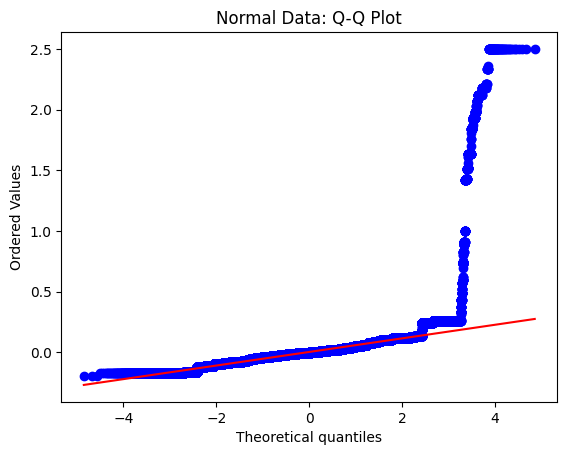

--- Testing Normal Data ---
Shapiro-Wilk: Statistic = 0.690, p-value = 0.000
Result: Data does not look normal (reject H0)

D'Agostino's K^2: Statistic=1868371.982, p-value = 0.000
Result: Data does not look normal (reject H0)



c:\Users\Saber\Desktop\research\MSTR-Options-Research-SwIRL\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1134063.
  res = hypotest_fun_out(*samples, **kwds)


In [95]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Q-Q Plot
stats.probplot(X, dist="norm", plot=plt)
plt.title('Normal Data: Q-Q Plot')
plt.show()

# --- Statistical Tests ---

print("--- Testing Normal Data ---")
# Shapiro-Wilk Test
shapiro_stat, shapiro_p = stats.shapiro(X)
print(f"Shapiro-Wilk: Statistic = {shapiro_stat:.3f}, p-value = {shapiro_p:.3f}")
if shapiro_p > 0.05: 
    print("Result: Data looks normal (fail to reject H0)\n")
else:
    print("Result: Data does not look normal (reject H0)\n")

# D'Agostino's K-squared Test
k2_stat, k2_p = stats.normaltest(X)
print(f"D'Agostino's K^2: Statistic={k2_stat:.3f}, p-value = {k2_p:.3f}")
if k2_p > 0.05:
    print("Result: Data looks normal (fail to reject H0)\n")
else:
    print("Result: Data does not look normal (reject H0)\n")


# Non-parametric Fit

- chi sqr GOF with normal assumption
- approximate beta params and chi sqr GOF with KDE 

## Fitting KDE

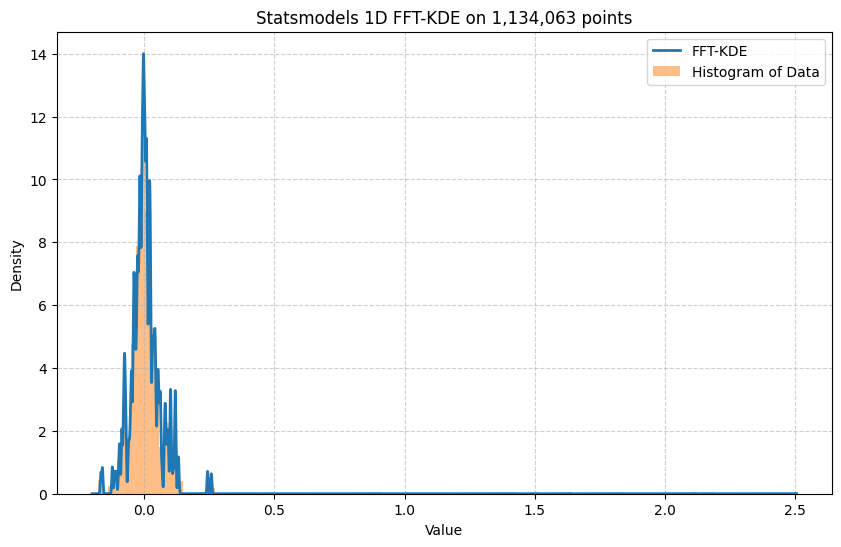

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kde import KDEUnivariate

# 2. Instantiate the KDEUnivariate class
# This class is specifically for 1D data.
kde = KDEUnivariate(X)

# 3. Fit the model
# bw='silverman': Uses Silverman's rule-of-thumb for bandwidth selection.
# fft=True: Explicitly tells it to use the FFT-based method.
#         (This is often the default, but it's good to be explicit).
# gridsize: Optionally, you can suggest the number of grid points for the FFT.
kde.fit(bw='silverman', fft=True)

# 4. Access the results
# The results are pre-computed and stored in the object.
# kde.support: The x-axis grid points where the density was evaluated.
# kde.density: The y-axis density (KDE) values at each support point.

# 5. Plot the results
plt.figure(figsize=(10, 6))
plt.plot(kde.support, kde.density, lw=2, label='FFT-KDE')

# (Optional) Plot a histogram to compare
plt.hist(X, bins=150, density=True, alpha=0.5, label='Histogram of Data')
plt.title(f'Statsmodels 1D FFT-KDE on {len(X):,} points')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Parametric Fit: Non-Central T

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# 2. Fit the Non-Central t-distribution
# 'nct' models both degrees of freedom (tails) and non-centrality (skew)
# It returns (df, nc, loc, scale) 
params = stats.nct.fit(X)
df_est, nc_est, loc_est, scale_est = params

print(f"Fitted Params -> DF: {df_est:.2f}, Skew(nc): {nc_est:.2f}, Loc: {loc_est:.2f}, Scale: {scale_est:.2f}")

Fitted Params -> DF: 3.33, Skew(nc): 0.38, Loc: -0.02, Scale: 0.04


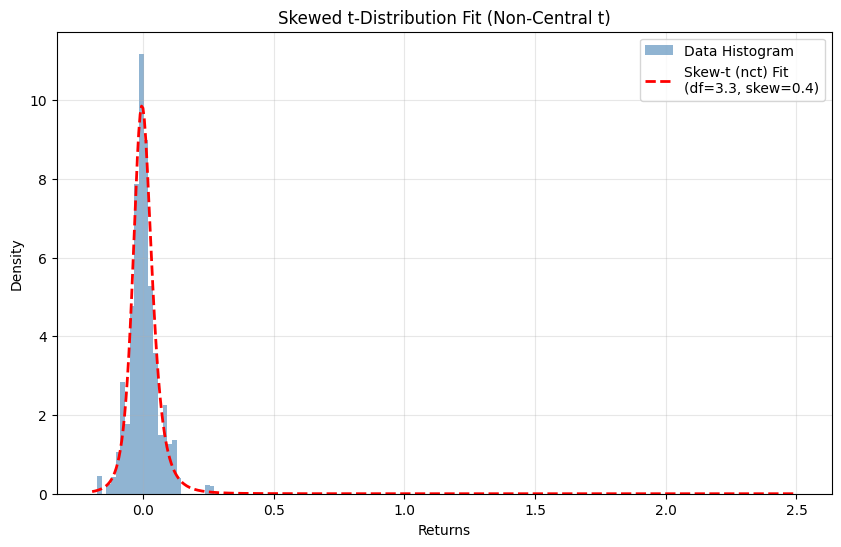

In [124]:
x = np.linspace(X.min(), X.max(), 500)

plt.figure(figsize=(10, 6))

# Plot the histogram of the data
plt.hist(X, bins=150, density=True, alpha=0.6, color='steelblue', label='Data Histogram')

# Plot the PDF of the fitted distribution
pdf_values = stats.nct.pdf(x, df_est, nc_est, loc_est, scale_est)
plt.plot(x, pdf_values, 'r--', lw=2,
         label=f'Skew-t (nct) Fit\n(df={df_est:.1f}, skew={nc_est:.1f})')

plt.title('Skewed t-Distribution Fit (Non-Central t)')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()